In [99]:
from datetime import datetime
import re
import os
import json
import sys

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple

In [100]:
# helper functions

# https://stackoverflow.com/questions/17060039/split-string-at-nth-occurrence-of-a-given-character
def splitn(string, spliton, n):
    """split 'string' on nth occurence of 'spliton'
    """
    groups = string.split(spliton)
    return spliton.join(groups[:n]), spliton.join(groups[n:])


def ms_delta(t):
    """convert timedelta t to milliseconds
    """
    return round(t.seconds * 1000 + t.microseconds / 1000)

In [101]:
# settings and configuration

# print output for debugging
verbose = False

# directory that contains *only* log files
logpath = "logs/"

# these are columns that define a single trial
columns = ['Participant',            # participant id (P01, P02, ...)
#            'Order',                  # what condition order this particpant did 
           'Condition',              # what condition this particpant did (typing, pointing, posture)
           'Block',                  # upto 3
           'Sequence',               # upto 14
           'Trial',                  # upto 7
           'Mode_Switching_Time',    #time in ms to switch from previous task to this one
           'Trial_Completion_Time',  #time in ms
           'Errors',                 # number of errors
            ]

# time format in the example log is like 2018/07/10-16:41:54.4902
# see https://docs.python.org/2/library/datetime.html#strftime-and-strptime-behavior
# time_format = '%Y/%m/%d-%H:%M:%S.%f'
time_format = '%Y-%m-%d %H:%M:%S.%f'


In [102]:
# parsing loop

# open the output datafile and write the column headers
data = open('data.csv', 'w')
data.write(','.join(columns) + '\n')

logpath = "/home/nchhibbe/sketchbook/typealike/log/test/"
# each log in the directory will be processed, order shouldn't matter
logfns = os.listdir(logpath)
print(logfns)

modeSwitch=False
currentTaskFirstAttempt=0;
previousTaskEndTime=0;
nextTaskStart=False;

for logfn in logfns:

    print(logfn)
    

    log = open(logpath + logfn, 'r')
    
    # initalize a dictionary of values we'll write to the datafile
    d = {e:0 for e in columns}
    
    # initalize temporary values
    trial_start_time = 0

    # we'll go through line-by-line
    line_num = 0
    for row in log:   
        
        # print some feedback
        line_num += 1
        if line_num % 1000 == 0: print(' {}'.format(line_num))
            
        # could identify and i log comments here ...
        if row[0] == '#':             
            continue
        
        # split the line
        rr = row.strip().split(',')
        t = str(datetime.fromtimestamp(int(rr[0])/1000))
        if "." not in t:
            t+=".0"
        # every line must start with: timestamp, type, subtype
        ts = datetime.strptime(t, time_format)
        et = (rr[1], rr[2])
        
        # input events are special
        if et[0] == 'M' or et[0] == 'keypressed':
            # rest of line is CSV
            pass
        if et[0] == 'I':
            if modeSwitch and nextTaskStart:
                currentTaskFirstAttempt = int(rr[0])
                modeSwitch=False
            pass
            
        else:
            # resplit on 3rd delimiters (json has commas too)
            r = splitn(row, ',', 3)
            
            try:
                # parse the json event data
                print(r[1])
                ed = json.loads(r[1])
            except Exception as e:
                print('error parsing json event data on row{}: {}\n{}'.format(rownum, r, e))
 
            # handle experiment 
            if et == ('E', 'experiment'):
                d['Participant'] = ed['participantid']
            
            elif et == ('E', 'block'):
                # block is just a number
                d['Block'] = int(ed['num'])

            elif et == ('E', 'sequence'):
#                 print(ed)
#                 if ed['type'] == "start":
#                     d['Order'] = ed['taskOrder']
                # sequence is a number
                d['Sequence'] = int(ed['num'])
                
#             elif et == ('E', 'task'):
#                 # check if this task event is an error
#                 if ed['action'] == 'failure':
#                     d['Errors'] += 1
                
            elif et == ('E', 'trial'):
                # trials should be 1, 2, 3, ... for each sequence
                d['Trial'] = int(ed['num'])
                d['Condition'] = ed['targetType']
                
                if ed['type'] == "start":
                    nextTaskStart = True
                # if not first trial, calculate any trial stats and save to log
                if ed['type'] == "end":
                    d['Mode_Switching_Time'] = currentTaskFirstAttempt- previousTaskEndTime
                    previousTaskEndTime = int(rr[0])
                    modeSwitch = True
                    nextTaskStart = False
                    print(ed['action'])
                    if ed['action'] == 'miss':
                        d['Errors'] = 1

                    # calculate stats
                    # trial_duration = ts - trial_start_time
#                     print(ed['duration'][2:7])
#                     print(ed['duration'][2:7].replace(".",""))
                    dur = re.search(r'\d+.?\d*', ed['duration'])
                    d['Trial_Completion_Time'] = int(dur.group().replace(".",""))# ms_delta(trial_duration)
                    
                    # save to log
                    datarow = [d[k] for k in columns]
                    datarow_csv = ','.join(str(i) for i in datarow)
#                     print(datarow_csv)
                    data.write(datarow_csv + '\n')
                    
                    # reset trial counters or accumulators
                    d['Errors'] = 0
                
                trial_start_time = ts


data.close()

['P00_experiment_2018-08-29-03-08-11.txt']
P00_experiment_2018-08-29-03-08-11.txt
{"type":"start","participantid":"P00","study":"two","datetime":"2018-08-29T07:08:11.705Z"}

{"type":"start","num":"0","numBlocks":"3","datetime":"2018-08-29T07:08:11.729Z"}

{"type":"start","blockNum":"0","num":"0","taskOrder":"0","datetime":"2018-08-29T07:08:11.739Z"}

{"type":"start","label":"Royal","targetType":"word","sequenceNum":"0","blockNum":"0","num":"0","startX":"1312","startY":"0","width":"100","height":"100","datetime":"2018-08-29T07:08:11.740Z"}

{"type":"end","label":"Royal","action":"hit","currScore":"0","targetType":"word","num":"0","sequenceNum":"0","blockNum":"0","datetime":"2018-08-29T07:08:15.057Z","duration":"PT3.317S"}

hit
{"type":"start","label":"(i<5)","targetType":"equation","sequenceNum":"0","blockNum":"0","num":"1","startX":"1434","startY":"0","width":"100","height":"100","datetime":"2018-08-29T07:08:15.088Z"}

{"type":"end","label":"(i<5)","action":"hit","currScore":"10","targ

In [103]:
# quick data checks with pandas
df = pd.read_csv('data.csv')
df.head()

,Participant,Condition,Block,Sequence,Trial,Mode_Switching_Time,Trial_Completion_Time,Errors
0,P00,word,0,0,0,0,3317,0
1,P00,equation,0,0,1,70,3724,0
2,P00,shortcut,0,0,2,129,6671,0
3,P00,equation,0,0,3,155,227,0
4,P00,posture,0,0,4,85,55,0


In [104]:
# check if each participant has the same number of trials per condition
df.groupby(['Participant', 'Condition']).count()['Trial_Completion_Time']

Participant  Condition
P00          click        15
             equation     17
             posture      17
             shortcut     16
             word         19
Name: Trial_Completion_Time, dtype: int64

In [105]:
df.groupby('Condition').mean()

,Block,Sequence,Trial,Mode_Switching_Time,Trial_Completion_Time,Errors
Condition,,,,,,
click,0.266667,5.800000,1.466667,486.733333,2745.600000,0.000000
equation,0.000000,7.411765,1.764706,436.588235,2936.470588,0.000000
posture,0.176471,5.529412,2.764706,129.705882,1853.352941,0.117647
shortcut,0.125000,5.750000,2.625000,120.187500,2248.937500,0.000000
word,0.263158,3.631579,1.315789,661.210526,2169.684211,0.052632


In [106]:
prevItem=nextItem=""
# Dictionary for (#CumulativeModeSwitchingTime, #numOfModeSwitches) for all mode switches
modeDict={
    ("word","shortcut"):[0,0],("word","click"):[0,0],("word","posture"):[0,0],("word","equation"):[0,0],
    ("shortcut","word"):[0,0],("click","word"):[0,0],("posture","word"):[0,0],("equation","word"):[0,0],
    ("shortcut","click"):[0,0],("shortcut","posture"):[0,0],("shortcut","equation"):[0,0],
    ("click","shortcut"):[0,0],("posture","shortcut"):[0,0],("equation","shortcut"):[0,0],
    ("click","posture"):[0,0],("click","equation"):[0,0],
    ("posture","click"):[0,0],("equation","click"):[0,0],
    ("posture","equation"):[0,0],("equation","posture"):[0,0],}
for index,row in df.iterrows():
    if index == 0:
        prevItem = row[1]
        pass
    if(prevItem!=row[1]):
        modeDict[(prevItem,row[1])][0] += row[5]
        modeDict[(prevItem,row[1])][1] += 1
    prevItem = row[1]

In [107]:
avgModeSwitchingTime={}
for index in modeDict:
#     print(modeDict[index])
    if modeDict[index][1] != 0:
        avgModeSwitchingTime[index] = modeDict[index][0]/modeDict[index][1]
    else:
        avgModeSwitchingTime[index] = 0

In [108]:
avgModeSwitchingTime

{('word', 'shortcut'): 128.33333333333334,
 ('word', 'click'): 114.0,
 ('word', 'posture'): 123.2,
 ('word', 'equation'): 107.0,
 ('shortcut', 'word'): 110.0,
 ('click', 'word'): 192.0,
 ('posture', 'word'): 1789.8333333333333,
 ('equation', 'word'): 0,
 ('shortcut', 'click'): 93.5,
 ('shortcut', 'posture'): 0,
 ('shortcut', 'equation'): 135.66666666666666,
 ('click', 'shortcut'): 90.5,
 ('posture', 'shortcut'): 0,
 ('equation', 'shortcut'): 121.5,
 ('click', 'posture'): 139.0,
 ('click', 'equation'): 227.0,
 ('posture', 'click'): 896.7142857142857,
 ('equation', 'click'): 0,
 ('posture', 'equation'): 1355.75,
 ('equation', 'posture'): 129.125}

In [109]:
modeDict.values()

dict_values([[770, 6], [114, 1], [616, 5], [321, 3], [440, 4], [960, 5], [10739, 6], [0, 0], [561, 6], [0, 0], [814, 6], [181, 2], [0, 0], [972, 8], [556, 4], [681, 3], [6277, 7], [0, 0], [5423, 4], [1033, 8]])

In [110]:
616/5

123.2

No handles with labels found to put in legend.


[128.33333333333334, 114.0, 123.2, 107.0, 110.0, 192.0, 1789.8333333333333, 0, 93.5, 0, 135.66666666666666, 90.5, 0, 121.5, 139.0, 227.0, 896.7142857142857, 0, 1355.75, 129.125]


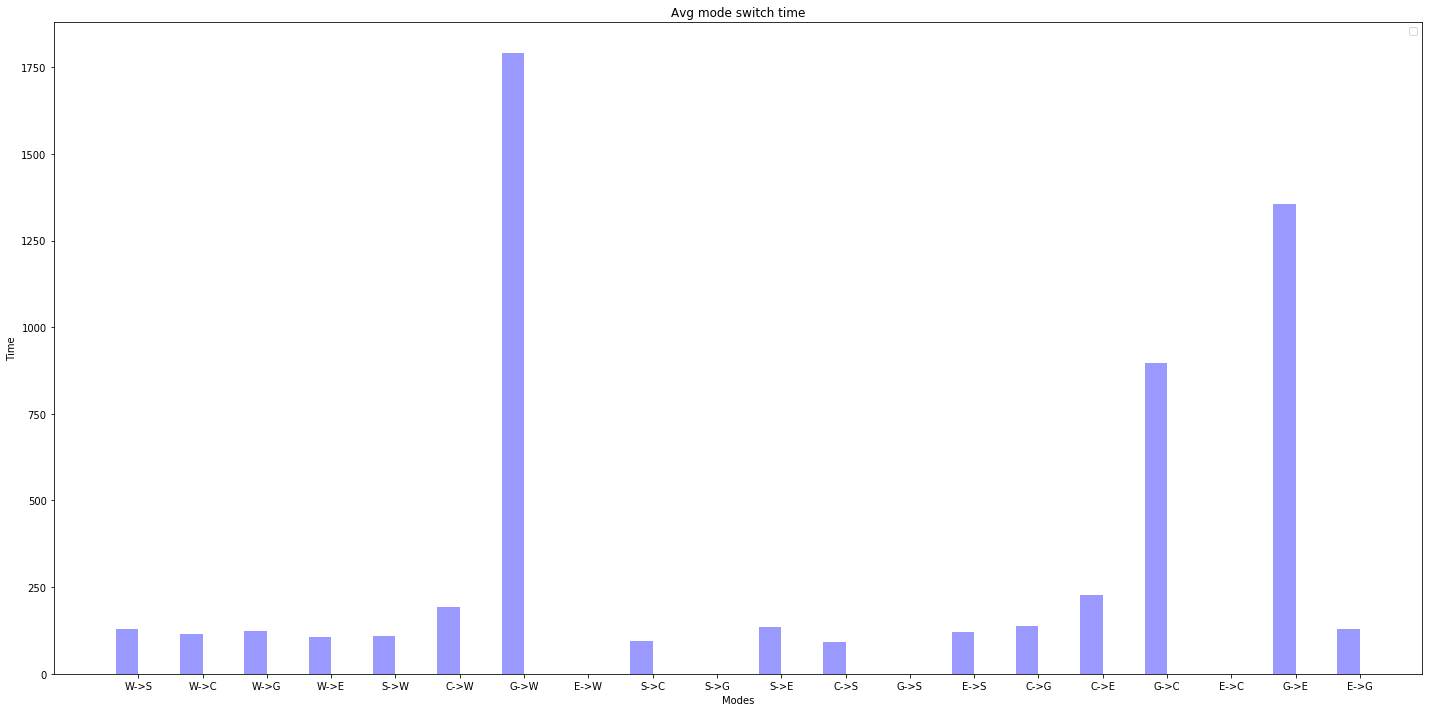

In [119]:
n_groups = 20

means_men = (20, 35, 30, 35, 27)
mean_modeswitch = list(avgModeSwitchingTime.values())
print(mean_modeswitch)
# std_men = (2, 3, 4, 1, 2)

means_women = (25, 32, 34, 20, 25)
std_women = (3, 5, 2, 3, 3)

fig, ax = plt.subplots(figsize=(20, 10))

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, mean_modeswitch, bar_width,
                alpha=opacity, color='b')#,
                #yerr=std_men, error_kw=error_config,
                #label='Avg mode switching time')

ax.set_xlabel('Modes')
ax.set_ylabel('Time')
ax.set_title('Avg mode switch time')
ax.set_xticks(index + bar_width / 2)
# ('word', 'shortcut'): 128.33333333333334,
#  ('word', 'click'): 114.0,
#  ('word', 'posture'): 123.2,
#  ('word', 'equation'): 107.0,
#  ('shortcut', 'word'): 110.0,
#  ('click', 'word'): 192.0,
#  ('posture', 'word'): 1789.8333333333333,
#  ('equation', 'word'): 0,
#  ('shortcut', 'click'): 93.5,
#  ('shortcut', 'posture'): 0,
#  ('shortcut', 'equation'): 135.66666666666666,
#  ('click', 'shortcut'): 90.5,
#  ('posture', 'shortcut'): 0,
#  ('equation', 'shortcut'): 121.5,
#  ('click', 'posture'): 139.0,
#  ('click', 'equation'): 227.0,
#  ('posture', 'click'): 896.7142857142857,
#  ('equation', 'click'): 0,
#  ('posture', 'equation'): 1355.75,
#  ('equation', 'posture'): 129.125}
lab = ['W->S','W->C','W->G','W->E','S->W','C->W','G->W','E->W','S->C','S->G','S->E','C->S','G->S','E->S','C->G','C->E','G->C','E->C','G->E','E->G']
ax.set_xticklabels(lab)
# ax.set_xticklabels(avgModeSwitchingTime.keys())#('A', 'B', 'C', 'D', 'E'))
ax.legend()

fig.tight_layout()
plt.show()